<a href="https://colab.research.google.com/github/masterschool-content/retail_demand_forecast/blob/main/notebooks/ML_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Please create a copy of the notebook to play around and leave the original copy untouched for other students and intructors!

# Import all libraries we will need

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Connect to Goole Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the files with pandas

In [ ]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

In [ ]:
# Let's filter the data for one store and one item to keep it simple
store_ids = [1]
item_ids = [96995]
#Select data before April'14
max_date = '2014-04-01'


# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(item_ids)) & (chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-4-bd7586eec8b9>:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):


# Prepare data

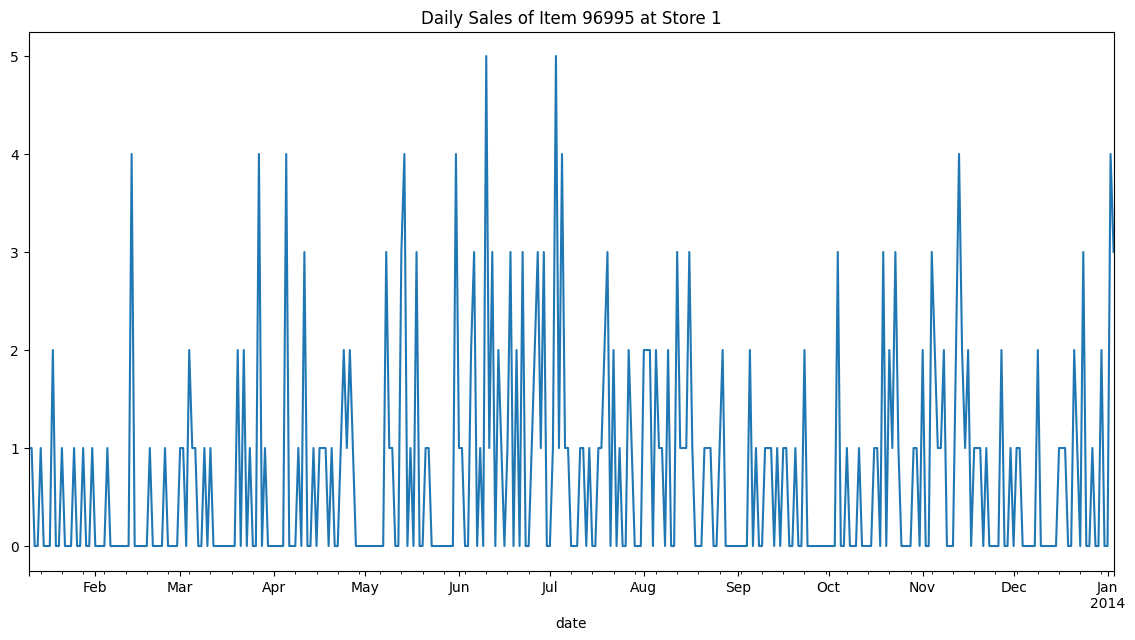

In [ ]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Group by date and aggregate sales
df_filtered = df_filtered.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales
df_filtered.set_index('date', inplace=True)
df_filtered = df_filtered.asfreq('D').fillna(0)

# Visualize sales data
plt.figure(figsize=(14, 7))
df_filtered['unit_sales'].plot()
plt.title('Daily Sales of Item 96995 at Store 1')
plt.show()

# Prepare features

## Creating Lag Features

In [ ]:
# Create lag features (e.g., sales from the previous day, previous week)
df_filtered['lag_1'] = df_filtered['unit_sales'].shift(1)
df_filtered['lag_7'] = df_filtered['unit_sales'].shift(7)
df_filtered['lag_30'] = df_filtered['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_filtered.dropna(inplace=True)

## Creating Rolling Statistics

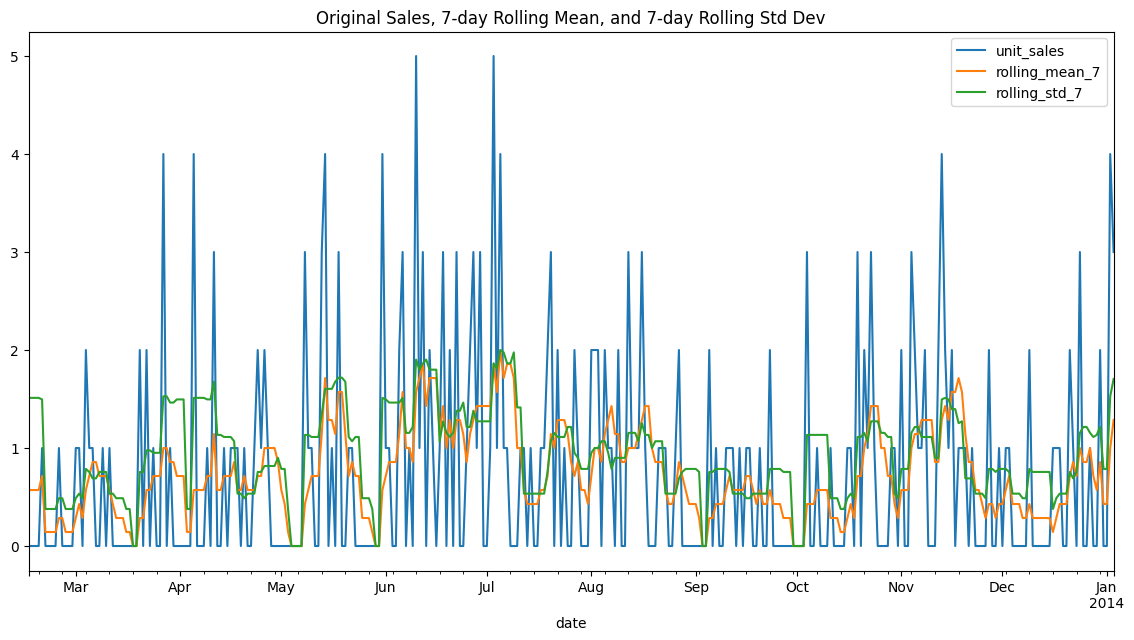

In [ ]:
# Create rolling mean and rolling standard deviation features
df_filtered['rolling_mean_7'] = df_filtered['unit_sales'].rolling(window=7).mean()
df_filtered['rolling_std_7'] = df_filtered['unit_sales'].rolling(window=7).std()

# Drop any NaN values after creating rolling features
df_filtered.dropna(inplace=True)

# Visualize the new features alongside the original sales
df_filtered[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

## Adding Date-based Features

In [ ]:
# Add date-based features
df_filtered['day_of_week'] = df_filtered.index.dayofweek
df_filtered['month'] = df_filtered.index.month
df_filtered['is_weekend'] = df_filtered['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Split data in training and test

In [ ]:
# Define target variable (unit_sales) and features
X = df_filtered.drop('unit_sales', axis=1)
y = df_filtered['unit_sales']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ML model with XGBoost

In [ ]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

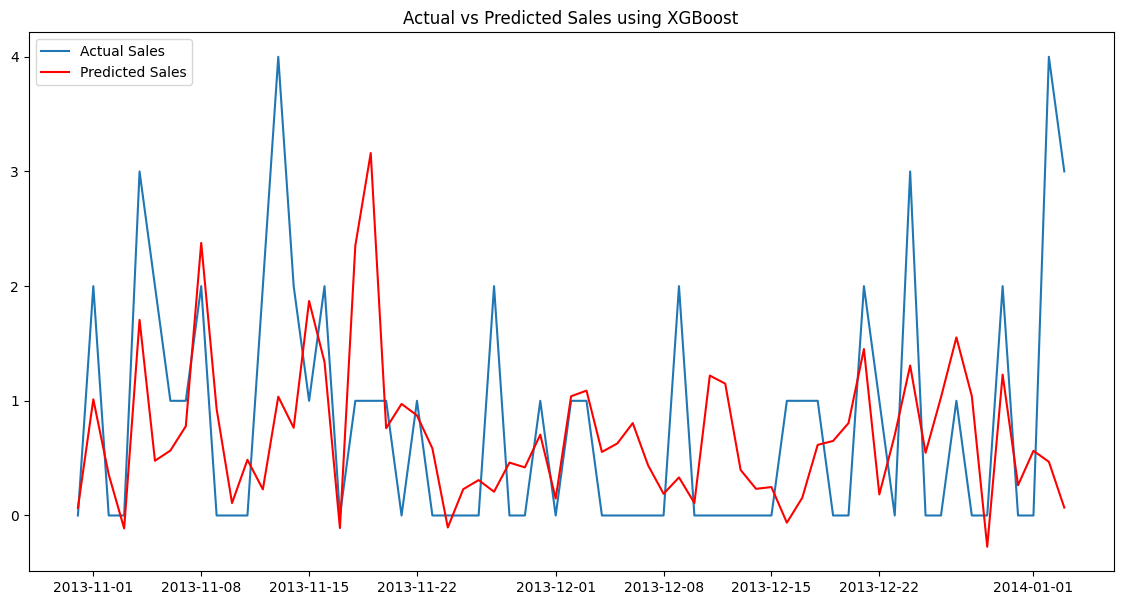

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()